# 0. 사전 세팅

In [1]:
!pip install wandb

In [46]:
!pip install torchinfo

In [47]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [48]:
# ------- Module 가져오기 ------- #
import os  # OS 모듈은 파일 경로 관련 작업을 위한 기본 모듈
from pathlib import Path  # 파일 경로를 객체 지향적으로 다룰 수 있는 모듈

import torch  # 딥러닝 텐서 연산을 위한 파이토치 메인 모듈
from torch import nn, optim  # 신경망 구축을 위한 신경망 모듈
from torch.utils.data import DataLoader, random_split  # 데이터 로딩 및 데이터 분할 관련 모듈
from torchvision import datasets, transforms
from torchinfo import summary

import matplotlib.pyplot as plt
import random
# ---------------------------- #

In [49]:
# ------- 컴퓨터 기본 정보를 받아오는 함수 가져오기 ------- #
# 다른 유틸리티 모듈에서 CPU 코어 수, OS 유형을 확인하는 함수를 가져옴
import os
import sys


def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False


def is_windows():
    if os.name == "nt":
        return True
    else:
        return False

def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    else:
        print("<unknown>")


Linux


# 1. Dataset 가져오기

각 입력 특성을 균일하게 다루기 위해 mean과 std 값을 데이터셋의 이미지 픽셀값의 평균과 이의 표준편차를 사용.

In [50]:
# ------- 최적의 Mean과 Std 값 계산 ------- #
def get_mean_std(loader):
    # 모든 데이터를 한 번에 로드하여 텐서로 변환
    images, _ = next(iter(loader))

    # 각 채널별로 평균과 표준편차 계산 (여기서는 채널이 하나뿐임)
    mean = images.mean()
    std = images.std()

    return mean.item(), std.item()

In [51]:
# ------- [Train용] Fashion MNIST datasets 가져오기 ------- #
def get_fashion_mnist_data():
    # 데이터를 다운로드하고 텐서 형태로 변환하여 Train set 로딩
    f_mnist_train = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # Train 데이터를 Train과 Validation으로 분할
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    # Mean과 Std 계산을 위한 DataLoader
    data_loader = DataLoader(dataset=f_mnist_train, batch_size=len(f_mnist_train), shuffle=False)
    images, _ = next(iter(data_loader))
    mean, std = images.mean().item(), images.std().item()
    print(f"Calculated mean: {mean}, std: {std}")

    # 정규화된 Transform 정의
    f_mnist_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean,), std=(std,))
    ])

    # Transform 적용된 Train 및 Validation 데이터셋 정의
    f_mnist_train = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=f_mnist_transforms
    )
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    # Train 및 Validation DataLoader 정의
    train_data_loader = DataLoader(dataset=f_mnist_train, batch_size=64, shuffle=True)
    validation_data_loader = DataLoader(dataset=f_mnist_validation, batch_size=64)

    return train_data_loader, validation_data_loader

In [52]:
# ------- [Test용] Fashion MNIST 데이터셋 가져오기 ------- #
def get_fashion_mnist_test_data(mean, std):
    ### Dataset 가져오기 ###
    f_mnist_test = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(mean,), std=(std,))
        ])
    )
    # 전체 Test 데이터를 한번에 로드할 수 있는 데이터 로더 정의 (Batch size = 전체 데이터셋)
    test_data_loader = DataLoader(
        dataset=f_mnist_test,
        batch_size=len(f_mnist_test)
    )

    return test_data_loader

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# ------- [Test용] Fashion MNIST 데이터셋 가져오기 ------- #
def get_fashion_mnist_test_data(mean, std):
    ### Dataset 가져오기 ###
    # Fashion MNIST 테스트 데이터를 다운로드 및 로드
    f_mnist_test = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(mean,), std=(std,))
        ])
    )

    # Test 데이터셋의 크기를 출력
    print("Num Test Samples: ", len(f_mnist_test))  # Test 데이터 샘플 수 출력
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    # 전체 Test 데이터를 한번에 로드할 수 있는 데이터 로더 정의 (Batch size = 전체 데이터셋)
    test_data_loader = DataLoader(
        dataset=f_mnist_test,
        batch_size=len(f_mnist_test)
    )

    # Test 데이터 로더 반환
    return test_data_loader



# 2. 모델 학습

In [54]:
# ------- 모델 학습을 위한 Trainer 클래스 ------- #
class FashionMNISTClassificationTrainer:
    def __init__(self, project_name, model, optimizer, train_data_loader, validation_data_loader, device, checkpoint_file_path):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        self.loss_fn = nn.CrossEntropyLoss()

    def train_loop(self, num_epochs):
        for epoch in range(num_epochs):
            # Training Phase
            self.model.train()
            total_train_loss = 0.0
            num_correct_train = 0
            num_samples_train = 0

            for train_batch in self.train_data_loader:
                inputs, targets = train_batch
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Accuracy calculation
                _, predicted = torch.max(outputs, 1)
                num_correct_train += (predicted == targets).sum().item()
                num_samples_train += targets.size(0)

            # Calculate training metrics
            avg_train_loss = total_train_loss / len(self.train_data_loader)
            train_accuracy = num_correct_train / num_samples_train

            # Validation Phase
            self.model.eval()
            total_val_loss = 0.0
            num_correct_val = 0
            num_samples_val = 0

            with torch.no_grad():
                for val_batch in self.validation_data_loader:
                    inputs, targets = val_batch
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = self.loss_fn(outputs, targets)
                    total_val_loss += loss.item()

                    # Accuracy calculation
                    _, predicted = torch.max(outputs, 1)
                    num_correct_val += (predicted == targets).sum().item()
                    num_samples_val += targets.size(0)

            # Calculate validation metrics
            avg_val_loss = total_val_loss / len(self.validation_data_loader)
            val_accuracy = num_correct_val / num_samples_val

            # Log metrics to WandB
            wandb.log({
                "Training Loss": avg_train_loss,
                "Validation Loss": avg_val_loss,
                "Training Accuracy": train_accuracy,
                "Validation Accuracy": val_accuracy
            })

            # Print Epoch Results
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [55]:
# ------- 샘플 테스트 데이터 분류 예측 확인 함수 ------- #
def evaluate_sample_predictions(model, test_data_loader, device):
    # 모델을 평가 모드로 설정
    model.eval()

    # Test 데이터셋에서 10개의 임의 샘플 선택
    test_images, test_labels = next(iter(test_data_loader))
    random_indices = random.sample(range(len(test_images)), 10)
    selected_images = test_images[random_indices]
    selected_labels = test_labels[random_indices]

    # 모델을 사용하여 예측 수행
    with torch.no_grad():
        inputs = selected_images.to(device)
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)

    # 이미지 출력 및 예측 결과 비교
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    for i in range(10):
        image = selected_images[i].squeeze(0).cpu()  # 이미지를 CPU로 이동 및 차원 축소
        actual_label = selected_labels[i].item()
        predicted_label = predicted_labels[i].item()

        # 이미지 출력
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {class_names[actual_label]}, Predicted: {class_names[predicted_label]}")
        plt.axis('off')
        plt.show()

        # 실제 레이블과 예측 결과 비교
        if actual_label == predicted_label:
            print(f"Sample {i+1}: Correctly Classified")
        else:
            print(f"Sample {i+1}: Misclassified")
            print(f"  -> Misclassification Explanation: This image was misclassified as '{class_names[predicted_label]}', while it should be '{class_names[actual_label]}'.")


# 3. 실행

Training Accuracy,▁▆█
Training Loss,█▃▁
Validation Accuracy,▁▅█
Validation Loss,█▃▁
Training Accuracy,0.90147
Training Loss,0.2767
Validation Accuracy,0.91
Validation Loss,0.24245


Calculated mean: 0.2861887216567993, std: 0.3530576229095459
Epoch [1/20], Train Loss: 0.4832, Train Accuracy: 0.8254, Val Loss: 0.3046, Val Accuracy: 0.8866
Epoch [2/20], Train Loss: 0.3296, Train Accuracy: 0.8820, Val Loss: 0.2971, Val Accuracy: 0.8902
Epoch [3/20], Train Loss: 0.2842, Train Accuracy: 0.8978, Val Loss: 0.2430, Val Accuracy: 0.9074
Epoch [4/20], Train Loss: 0.2520, Train Accuracy: 0.9080, Val Loss: 0.2333, Val Accuracy: 0.9104
Epoch [5/20], Train Loss: 0.2306, Train Accuracy: 0.9157, Val Loss: 0.2214, Val Accuracy: 0.9202
Epoch [6/20], Train Loss: 0.2112, Train Accuracy: 0.9234, Val Loss: 0.2215, Val Accuracy: 0.9156
Epoch [7/20], Train Loss: 0.1942, Train Accuracy: 0.9296, Val Loss: 0.2108, Val Accuracy: 0.9216
Epoch [8/20], Train Loss: 0.1770, Train Accuracy: 0.9348, Val Loss: 0.2109, Val Accuracy: 0.9250
Epoch [9/20], Train Loss: 0.1680, Train Accuracy: 0.9381, Val Loss: 0.2092, Val Accuracy: 0.9264
Epoch [10/20], Train Loss: 0.1524, Train Accuracy: 0.9440, Val Los

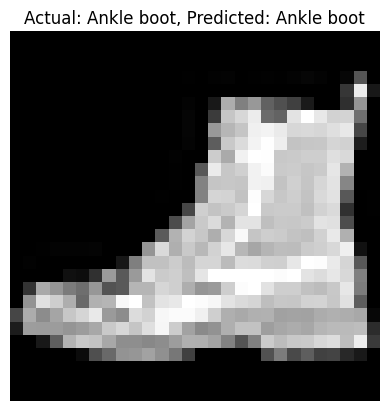

Sample 1: Correctly Classified


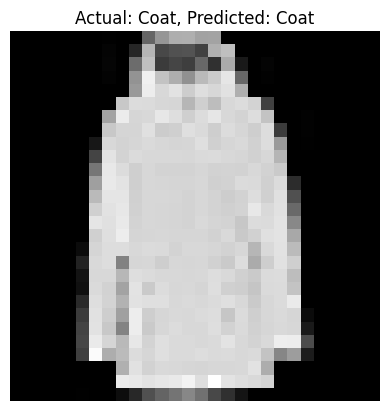

Sample 2: Correctly Classified


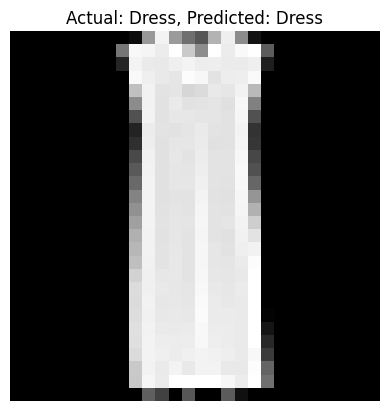

Sample 3: Correctly Classified


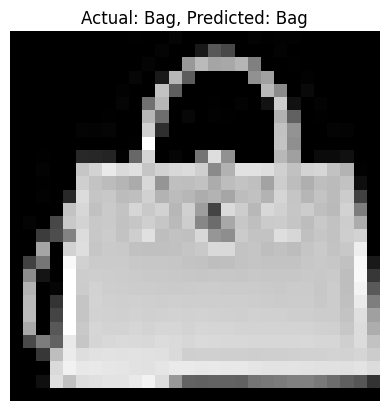

Sample 4: Correctly Classified


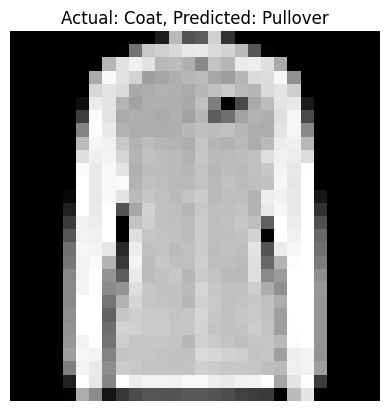

Sample 5: Misclassified
  -> Misclassification Explanation: This image was misclassified as 'Pullover', while it should be 'Coat'.


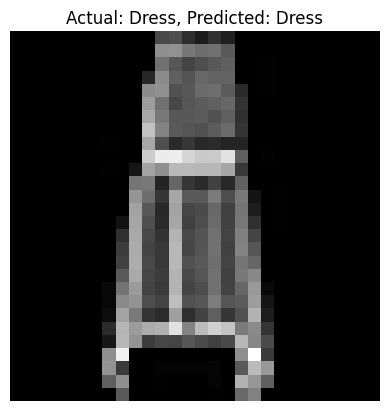

Sample 6: Correctly Classified


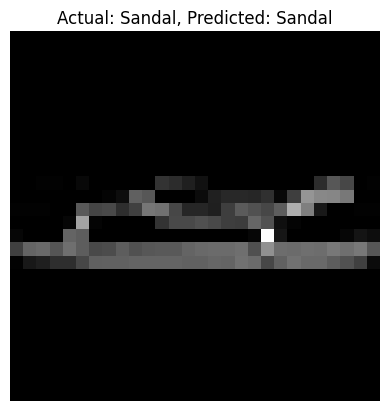

Sample 7: Correctly Classified


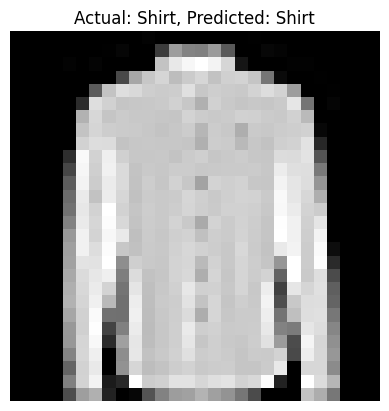

Sample 8: Correctly Classified


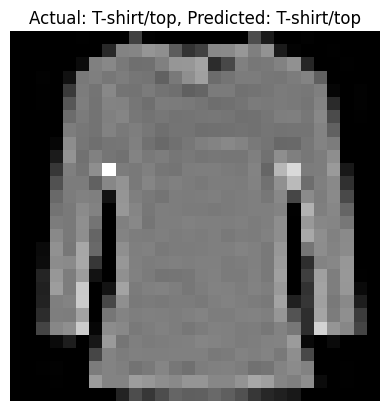

Sample 9: Correctly Classified


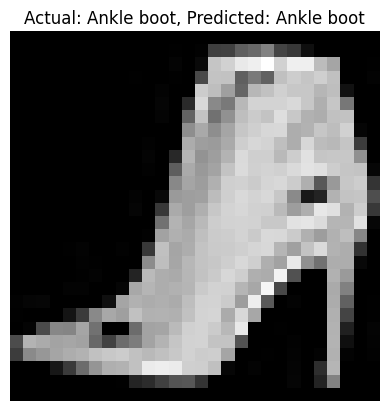

Sample 10: Correctly Classified


In [56]:
# ------- Main 함수 ------- #
if __name__ == "__main__":
    # WandB 설정 초기화
    wandb.init(project="fashion_mnist_cnn", config={
        "epochs": 20,
        "batch_size": 32,
        "learning_rate": 0.001
    })
    config = wandb.config

    # Train 및 Validation DataLoader 생성
    train_data_loader, validation_data_loader = get_fashion_mnist_data()

    # 모델 정의 (간단한 CNN)
    class SimpleCNN(nn.Module):
        def __init__(self):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.fc1 = nn.Linear(64 * 7 * 7, 128)
            self.fc2 = nn.Linear(128, 10)
            self.pool = nn.MaxPool2d(2, 2)
            self.relu = nn.ReLU()
            self.gelu = nn.GELU()
            self.dropout = nn.Dropout(0.5)


        def forward(self, x):
            x = self.gelu(self.pool(self.bn1(self.conv1(x))))
            x = self.gelu(self.pool(self.bn2(self.conv2(x))))
            x = x.view(-1, 64 * 7 * 7)
            x = self.gelu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # 모델, 디바이스, 옵티마이저 정의
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    summary(model, input_size=(64, 1, 28, 28), device="cuda" if torch.cuda.is_available() else "cpu")


    # 트레이너 인스턴스 생성 및 학습 시작
    trainer = FashionMNISTClassificationTrainer(
        "fashion_mnist_cnn", model, optimizer, train_data_loader, validation_data_loader, device, "./checkpoints"
    )
    trainer.train_loop(num_epochs=config.epochs)

    # Mean과 Std를 얻어서 Test 데이터 로더 생성
    data_loader = DataLoader(dataset=datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()), batch_size=len(datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())))
    mean, std = get_mean_std(data_loader)

    # Test 데이터 로더 생성
    test_data_loader = get_fashion_mnist_test_data(mean, std)

    # 모델 평가 (Test 데이터셋에 대한 전체 성능)
    model.eval()
    num_correct_test = 0
    num_samples_test = 0
    total_test_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_batch in test_data_loader:
            inputs, targets = test_batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            num_correct_test += (predicted == targets).sum().item()
            num_samples_test += targets.size(0)

    # Test metrics 계산
    avg_test_loss = total_test_loss / len(test_data_loader)
    test_accuracy = num_correct_test / num_samples_test

    # Test 결과 출력
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # WandB에 Test 결과 기록
    wandb.log({
        "Test Loss": avg_test_loss,
        "Test Accuracy": test_accuracy
    })

    # 10개의 샘플에 대해 분류 예측 결과 확인
    evaluate_sample_predictions(model, test_data_loader, device)

## Hyperparaeter
현재 코드에서의 Hyper parameter들은 다음과 같다.  
lr = 0.001(기본 값)  
epoch = 20 (10->20)  
batch size = 32 (64->32)  
  

### lr을 기본 값으로 설정한 이유
lr을 0.0005와 0.01일 때 둘 다 실험해보았다.   
lr이 클 경우 처음부터 Train Loss가 크고 Train Accuracy가 낮음을 확인하였다. 이후 반복 학습을 통해(여러 에폭 순회를 통해) Loss가 줄어들고 Accuracy가 증가하는 속도는 나쁘지 않음을 확인하였으나, 처음부터 큰 오류율을 가지고 있었기에 빠르게 오류를 줄인다하더라도 오류율이 드라마틱하게 낮아지지도, 그렇게 만들 수 있을 정도로 엄청나게 빠른 속도가 아니었다. 결과적으로 0.001일 때보다 성능이 좋지 못하였다.  
lr이 작을 경우 초반의 Train Loss와 Accuracy는 0.001과 비슷하거나 조금 더 적은 수준이었다. 그러나 학습률이 적기에 빠른 개선이 어려워 같은 에폭일 때 결과적으로 더 높은 오류율을 보였다.  
그러므로 기본 값으로 제시된 0.001이 가장 적합하다고 생각하여 이를 사용하였다.  
  
### epoch을 증가시킨 이유
기본 값인 10회로 학습했을때, 매 회마다 이전 회차보다 Loss가 감소하고 Accuracy가 증가하는 것이 눈에 띄게 느껴졌으므로 epoch 수를 증가시켰다.

### batch size를 축소한 이유
배치 사이즈를 줄이니 이전보다 오류율이 더 적은 것을 확인할 수 있었다. 작은 배치 사이즈를 이용하면 overfitting을 방지할 수 있어 일반화 성능을 높일 수 있다.

### Coat를 Pullover로 착각한 이유
코트와 풀오버는 굉장히 비슷하게 생겼다. 이로 인해 더 상세히 학습해야하는 면이 있다. 현재 드롭 아웃을 0.5로 사용하고 있는데, 이 때문에 많은 뉴런이 비활성화 되어 정보 손실이 이루어질 수 있기에 코트와 풀오버를 구분하지 못했나 싶다. 드롭아웃 비율을 줄이면 아마 괜찮을 것이다. 또한 은닉층을 지금 2개만 사용하고 있는데 더 복잡한 구조로 가면 좀 더 세세하게 학습할 수 있을 것이다.

# 숙제 후기
MNIST 데이터셋을 이용한 분류는 많이 해보았는데 **Fashion MNIST**를 사용한 분류는 처음이라서 신선했다. 정확도를 93% 이상으로 높이고 싶었는데 아무리 하이퍼 파라미터를 바꿔봐도 92.4%를 넘지 못했었다. 기존에 있는 많은 하이퍼 파라미터 최적화 기법을 이용해 자동으로 하이퍼 파라미터를 튜닝해주는 코드를 작성하여 넣었으면 좋았겠다 싶었다.